While the 1D Ising model does not yet feature a phase transition, the 2D Ising model already does. This can be seen e.g. in the analytical result for the absolute magnetisation per particle for $H = 0$. where $T_{c}$ is the Curie temperature at which the phase transition occurs.
Implement a 2D Ising model on a square lattice with $n = \sqrt{N} = 20$ spins per side, again using periodic boundary conditions, $s_{n+1,j} = s_{1,j}$ and $s{i,n+1} = s{i,1}$, connecting sides with each other. Calculate the absolute magnetisation of the model for $H = 0$ in dependence of the thermal energy $k_{B}T$ with the same techniques used for the 1D model. Note that more time might be needed to reach equilibrium. Discuss your results. Can you reproduce the predicted phase transition?1


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
seeds = np.load("seeds_3000x100.npy")

In [2]:
#generating 100 lists 3000 seeds
#seeds = []
#for i in range(100):
#    seeds_i = np.random.randint(0, 100000, size=3000)
#    seeds.append(seeds_i)
#seeds = np.array(seeds)
#np.save("seeds_3000x100", seeds)

In [3]:
def padding(a):
    bottom_row = np.array([a[-1]])
    top_row = np.array([a[0]])
    top_row_padded = np.concatenate((np.array([[0]]), top_row, np.array([[0]])), axis=1)
    bottom_row_padded = np.concatenate((np.array([[0]]), bottom_row, np.array([[0]])), axis=1)
    right_column = np.transpose([a[:,-1]])
    left_column = np.transpose([a[:,0]])
    a_cols = np.concatenate((right_column, a, left_column), axis=1)
    a_padded = np.concatenate((bottom_row_padded, a_cols, top_row_padded))
    return a_padded

def energy_2D(config, H_external=0, J=1):
    H = 0
    config_with_boundaries = padding(config)
    for i in range(1, config.shape[0]+1):
        for j in range(1, config.shape[1]+1):
            H_ij = config_with_boundaries[i][j]*(config_with_boundaries[i][j+1]+config_with_boundaries[i][j-1]+config_with_boundaries[i-1][j]+config_with_boundaries[i+1][j])
            H += H_ij
    H_ext = H_external * np.sum(config)
    return -(0.5*J*H+H_ext)

def metropolis_algorithm(initial_state, num_trials, beta, H_external=0, list_seeds=None):
    sequence_states = [initial_state]
    for n in range(num_trials):
        #try:
        #    sd = list_seeds[n]
        #except:
        #    sd = np.random.randint(100000)
        next_sequence = metropolis_step(sequence_states[-1], beta, H_external, seed = 5)
        sequence_states.append(next_sequence)
    return np.array(sequence_states), np.arange(num_trials+1)

def metropolis_step(current_state, beta, H_external, seed = None):
    #np.random.seed(seed)
    spin_flip_index = np.random.randint(0,current_state.shape[0], size=2)
    trial_configuration = copy.deepcopy(current_state)
    trial_configuration[spin_flip_index[0]][spin_flip_index[1]] *= -1
    energy_diff = energy_2D(trial_configuration, H_external) - energy_2D(current_state, H_external)
    trial_acceptance_prob = np.min([np.exp(-beta * energy_diff),1])
    r_accept = np.random.rand()
    if r_accept < trial_acceptance_prob:
        new_state = trial_configuration
    else:
        new_state = current_state
    return np.array(new_state)

def magnetisation(config):
    return np.sum(config)

def magnetisation_theor(beta, J=1):
    kT_c = 2.269185
    if 1/beta > kT_c:
        return 0
    else:
        z = np.exp(-2*J*beta)
        m_enum_1 = (1+z**2)**(1/4)
        m_enum_2 = (1-6*z**2 +z**4)**(1/8)
        m_denom = np.sqrt(1-z**2)
        return m_enum_1*m_enum_2/m_denom

In [10]:
N = 20
np.random.seed(42)
X_0 = np.random.choice([-1, 1], size=(N, N))
list_beta = np.array([50,40,30,20, 1.e+01, 1.e+00, 1/2.269186, 1/6 ,0.1])#np.array([0.1,1/2.269186, 1,6,10, 100])#1/np.linspace(1,4,10)
list_M = []

for b in list_beta:
    tnow = datetime.datetime.now()
    formatted_time = tnow.strftime("%H:%M:%S")
    print(f"Metropolis algorithm for k_B T = {1/b} starting at {formatted_time}")
    list_M_beta = []
    for i in range(10):
        states_m, _ = metropolis_algorithm(initial_state=X_0, num_trials=10000, beta=b) #Todo: Check if higher num trials needed
        states_m = states_m[-100:,:] #Keep only the equilibrium states
        mag_m = [magnetisation(state) for state in states_m]
        list_M_beta.append(mag_m)
    M_mean = np.mean(list_M_beta)
    list_M.append(M_mean)
    print(f"Mean magnetisation for k_B T = {1/b}: M = {M_mean}")

Metropolis algorithm for beta=50.0 starting at 20:05:01
Mean magnetisation for k_B T=0.02: M=173.14
Metropolis algorithm for beta=40.0 starting at 20:07:17
Mean magnetisation for k_B T=0.025: M=141.0254
Metropolis algorithm for beta=30.0 starting at 20:09:36
Mean magnetisation for k_B T=0.03333333333333333: M=205.5704
Metropolis algorithm for beta=20.0 starting at 20:11:42
Mean magnetisation for k_B T=0.05: M=135.518
Metropolis algorithm for beta=10.0 starting at 20:13:50
Mean magnetisation for k_B T=0.1: M=161.991
Metropolis algorithm for beta=1.0 starting at 20:15:58
Mean magnetisation for k_B T=1.0: M=168.041
Metropolis algorithm for beta=0.4406866603266546 starting at 20:18:04
Mean magnetisation for k_B T=2.269186: M=122.0476
Metropolis algorithm for beta=0.16666666666666666 starting at 20:20:11
Mean magnetisation for k_B T=6.0: M=18.5598
Metropolis algorithm for beta=0.1 starting at 20:22:24
Mean magnetisation for k_B T=10.0: M=20.1298


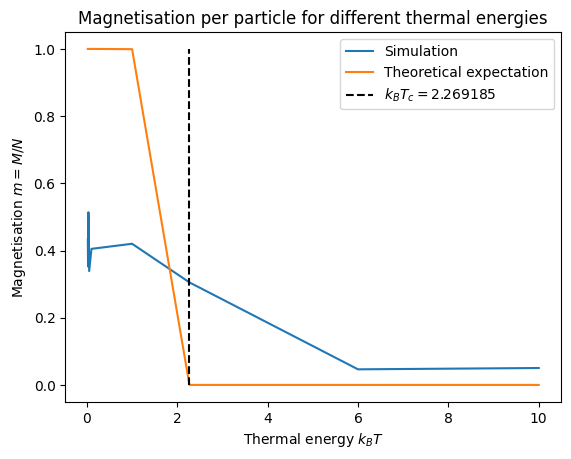

In [11]:
plt.plot(1/list_beta, np.array(list_M)/(N*N), label = "Simulation")
plt.plot(1/list_beta, [magnetisation_theor(b) for b in list_beta], label = f"Theoretical expectation")
plt.vlines(2.269185, 0, 1, "k", linestyles="dashed", label="$k_{B}T_{c}=2.269185$")
plt.title("Magnetisation per particle for different thermal energies")
plt.xlabel("Thermal energy $k_{B}T$")
plt.ylabel("Magnetisation $m = M/N$")
plt.legend()

In [12]:
list_M

[173.14,
 141.0254,
 205.5704,
 135.518,
 161.991,
 168.041,
 122.0476,
 18.5598,
 20.1298]

In [13]:
np.random.seed(42)
X_0 = np.random.choice([-1, 1], size=(N, N))
state_new, _ = metropolis_algorithm(X_0, 10000, beta=50)
magnetisation(state_new[-1])

256

In [8]:
state_new[-1]

array([[-1., -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,
        -1., -1., -1.,  1., -1.,  1., -1.],
       [ 1., -1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
        -1., -1., -1., -1.,  1., -1., -1.],
       [-1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,
        -1., -1., -1., -1.,  1., -1., -1.],
       [ 1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,
         1., -1., -1., -1., -1., -1.,  1.],
       [-1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
         1., -1., -1., -1.,  1.,  1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
         1., -1., -1.,  1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,  1.,
         1.,  1., -1., -1., -1.,  1., -1.],
       [-1.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
        -1.,  1., -1., -1.,  1., -1., -1.],
       [-1.,  1., -1.,  1., -1.,  1., -1., -1., -1., -1.,  1., -